In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [2]:
dir_path = '../../../data/pseudobulks/'

In [3]:
os.listdir(dir_path)

['annotation_chimp.csv',
 'annotation_human.csv',
 'annotation_macaque.csv',
 'annotation_spatial_libd_human.csv',
 'expression_chimp.csv',
 'expression_human.csv',
 'expression_macaque.csv',
 'expression_mean_chimp.csv',
 'expression_mean_human.csv',
 'expression_mean_macaque.csv',
 'expression_mean_spatial_libd_human.csv',
 'expression_spatial_libd_human.csv',
 'expression_sum_chimp.csv',
 'expression_sum_human.csv',
 'expression_sum_macaque.csv',
 'expression_sum_spatial_libd_human.csv',
 'gene_sample_mean_chimp.csv',
 'gene_sample_mean_human.csv',
 'gene_sample_mean_macaque.csv',
 'gene_sample_mean_spatial_libd_human.csv',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_age_sample_norm_zscore.h5ad',
 'pb_mamm.h5ad',
 'pb_mamm_sample_norm.h5ad',
 'pb_mamm_sample_norm_filtered.h5ad',
 'pb_mamm_sample_norm_zscore.h5ad']

# ANOVA

Загрузим файл псевдобалк экспрессий

In [4]:
file_name = 'pb_mamm.h5ad'
adata_pb = sc.read_h5ad(dir_path + file_name)
adata_pb

AnnData object with n_obs × n_vars = 94 × 15585
    obs: 'layer', 'sample_id', 'condition'

Посчитаем размер библиотек

In [5]:
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

## Фильтрация данных

Отберём слабо экспрессирующиеся гены

In [6]:
adata_pb = adata_pb[:, adata_pb.X.mean(axis=0) > 0.05]
adata_pb

View of AnnData object with n_obs × n_vars = 94 × 9177
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'

## Нормализация данных

In [7]:
def subtract_mean(adata):
    # calculate mean gene expr for each sample
    gene_mean_list = []
    sample_layer_list = adata.obs.sample_id.unique().tolist()
    for sample in sample_layer_list:
        gene_mean_list.append(adata[adata.obs.sample_id == sample].X.mean(axis=0).reshape(-1, 1))
    # convert to DataFrame
    gene_mean_df = pd.DataFrame(np.concatenate(gene_mean_list, axis=1), columns=sample_layer_list, index=adata.var_names)
    gene_mean_df.head()
    
    # subtract mean and return adata
    for sample in sample_layer_list:
        columns = adata.obs[adata.obs.sample_id == sample].index.to_list()
        for column in columns:
            adata[column].X = adata[column].X - gene_mean_df.loc[:, sample].values
    return adata

Нормализация на размер библиотеки

In [8]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Нормализация на образец

In [9]:
adata_norm = subtract_mean(adata_pb)

In [10]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


In [11]:
# сохраним результаты
adata_norm.write_h5ad('../../../data/pseudobulks/pb_mamm_sample_norm_filtered.h5ad')

Построим PCA

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


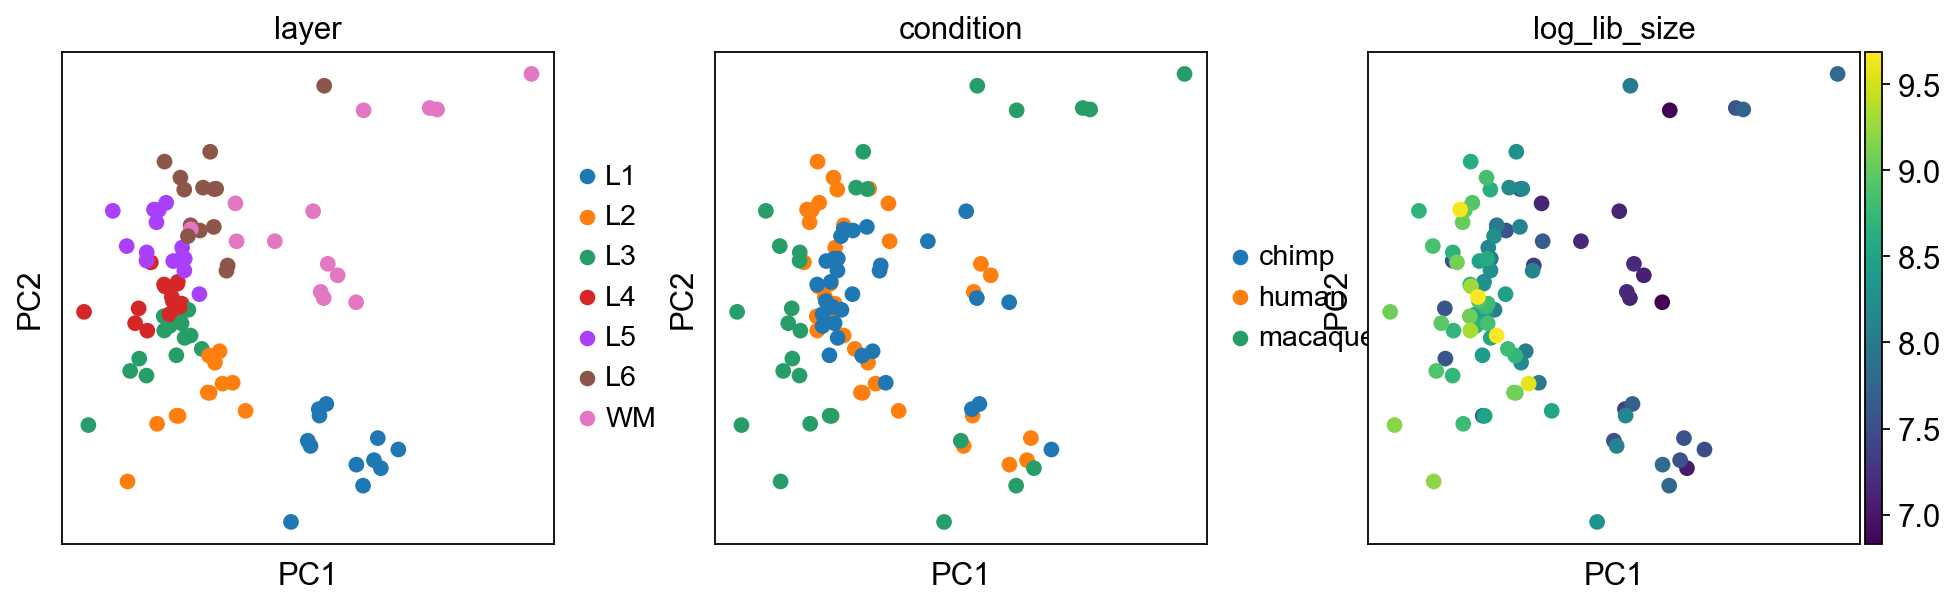

In [12]:
sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

## ANOVA

Загрузим файл нормлизованных экспрессий и уберём слабо экспрессирующиеся геныУберём слабо экспрессирующиеся гены

In [13]:
file_name = 'pb_mamm_sample_norm_filtered.h5ad'
adata = sc.read_h5ad(dir_path + file_name)
adata

AnnData object with n_obs × n_vars = 94 × 9177
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [14]:
# Сделаем датафрейм с сэмплами для ановы
df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
df['condition'] = adata.obs.condition
df['layer'] = adata.obs.layer
df.head()

,NOC2L,HES4,AGRN,SDF4,B3GALT6,UBE2J2,SCNN1D,ACAP3,PUSL1,INTS11,...,SPATC1L,LSS,MCM3AP,YBEY,PCNT,DIP2A,S100B,PRMT2,condition,layer
WM.human_759,-0.029441,0.000065,-0.043517,-0.047363,0.019739,0.073402,-0.025437,0.066414,-0.005996,0.083758,...,0.062820,0.006484,0.006105,-0.060444,0.043885,0.194320,-0.013049,0.086257,human,WM
L5.human_759,0.041376,-0.070898,0.081046,-0.035533,0.081751,0.024792,-0.044160,-0.004856,0.042265,-0.097728,...,0.031169,-0.011958,0.004413,0.048625,0.010839,-0.003846,-0.163199,-0.036209,human,L5
L2.human_759,0.003571,0.078188,-0.094585,0.048401,-0.015252,-0.041863,0.051233,-0.011440,-0.012877,0.011447,...,0.010243,-0.086682,-0.034960,0.014999,-0.022664,-0.073351,-0.099099,0.033290,human,L2
L3.human_759,0.014237,0.003693,0.055989,-0.024284,-0.030906,-0.005798,-0.020388,-0.024462,0.006017,0.040797,...,-0.056161,-0.006626,0.039248,-0.016340,-0.015441,-0.077773,-0.158475,-0.059096,human,L3
L1.human_759,-0.084829,0.076060,-0.060537,0.055300,-0.022040,-0.051892,-0.003293,-0.015931,-0.068753,0.025015,...,-0.047335,0.132053,-0.019641,0.023532,0.050180,0.009784,0.679253,0.060213,human,L1


Заменим названия генов на `gene{i}` а то `statsmodels` ругается

In [15]:
df_var_num = df.copy()
df_var_num.columns = [f'gene{i}' for i in range(1, df_var_num.shape[1] - 1)] + ['condition', 'layer']

In [16]:
# Anova для каждого гена
results = []

for gene in tqdm(df_var_num.columns.tolist()[:-2]):
    formula = f'{gene} ~ condition + layer + condition:layer'
    model = ols(formula, data=df_var_num).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    results.append(aov_table.loc['condition:layer'].tolist())

# запишем результаты в датасет
columns = ['sum_sq', 'df', 'F', 'PR(>F)']
res = pd.DataFrame(results, columns=columns, index=adata.var_names)
res.head()

  0%|          | 0/9177 [00:00<?, ?it/s]

,sum_sq,df,F,PR(>F)
NOC2L,0.050934,12.0,1.331623,2.198446e-01
HES4,0.047967,12.0,1.869576,5.257696e-02
AGRN,0.200630,12.0,3.592408,3.153396e-04
SDF4,0.014974,12.0,1.326877,2.223945e-01
B3GALT6,0.079358,12.0,6.536443,9.170559e-08


## Поправка на множественное сравнение

In [17]:
# поправка на множественые сравнения
mult_test = multipletests(res['PR(>F)'], method='fdr_bh')
res['p_val_adj'] = mult_test[1]
res.to_csv(f'../../../results/DE/mammals/ANOVA/anova_mamm.csv')

In [18]:
res.head()

,sum_sq,df,F,PR(>F),p_val_adj
NOC2L,0.050934,12.0,1.331623,2.198446e-01,2.964752e-01
HES4,0.047967,12.0,1.869576,5.257696e-02,9.164269e-02
AGRN,0.200630,12.0,3.592408,3.153396e-04,1.161898e-03
SDF4,0.014974,12.0,1.326877,2.223945e-01,2.993420e-01
B3GALT6,0.079358,12.0,6.536443,9.170559e-08,9.258330e-07


<AxesSubplot: >

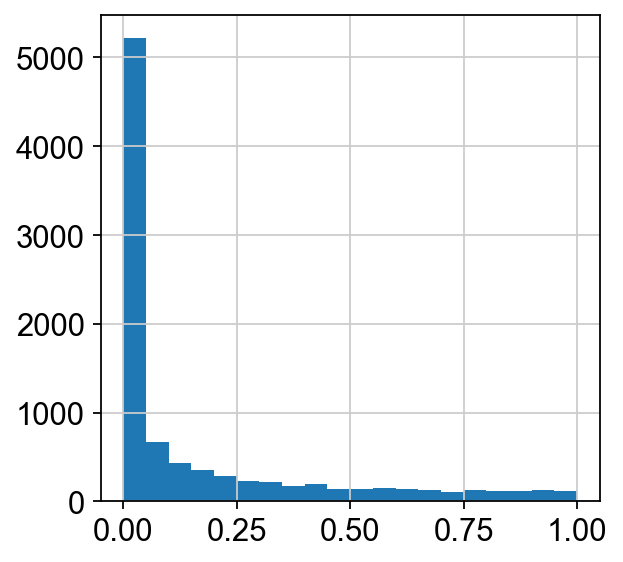

In [19]:
res['PR(>F)'].hist(bins=20)

## t-test

In [20]:
anova_res = pd.read_csv(f'../../../results/DE/mammals/ANOVA/anova_mamm.csv', index_col=0)
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
NOC2L,0.050934,12.0,1.331623,2.198446e-01,2.964752e-01
HES4,0.047967,12.0,1.869576,5.257696e-02,9.164269e-02
AGRN,0.200630,12.0,3.592408,3.153396e-04,1.161898e-03
SDF4,0.014974,12.0,1.326877,2.223945e-01,2.993420e-01
B3GALT6,0.079358,12.0,6.536443,9.170559e-08,9.258330e-07


Оставим только значимые по взаимодействию гены

In [21]:
sig_genes = anova_res[res.p_val_adj < 0.05].index
sig_genes

Index(['AGRN', 'B3GALT6', 'UBE2J2', 'DVL1', 'ANKRD65', 'VWA1', 'TMEM240',
       'SSU72', 'GNB1', 'TMEM52',
       ...
       'PFKL', 'CFAP410', 'ADARB1', 'COL18A1', 'COL6A2', 'SPATC1L', 'LSS',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', length=4680)

In [22]:
from itertools import combinations
layers = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']
conditions = ['human', 'chimp', 'macaque']

In [23]:
from scipy.stats import ttest_ind
from itertools import combinations

columns = ['gene', 'layer', 'group1', 'group2', 'score', 'pvalue']
results = []


for layer in tqdm(layers):
    layer_results = []
    for group1, group2 in combinations(conditions, 2):
        for gene in sig_genes.tolist():
            values1 = df.loc[(df['layer'] == layer) & (df['condition'] == group1), gene].values
            values2 = df.loc[(df['layer'] == layer) & (df['condition'] == group2), gene].values
            ttest_res = ttest_ind(values1, values2)
            layer_results.append([gene, layer, group1, group2, ttest_res.statistic, ttest_res.pvalue])
    # поправка на множественное сравнение
    layer_results = pd.DataFrame(layer_results, columns=columns)
    layer_results.dropna(subset='pvalue', inplace=True)
    mult_test = multipletests(layer_results['pvalue'], method='fdr_bh')
    layer_results['p_val_adj'] = mult_test[1]
    results.append(layer_results)

  0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
ttest_results = pd.concat(results)
ttest_results

,gene,layer,group1,group2,score,pvalue,p_val_adj
0,AGRN,L1,human,chimp,0.205461,0.844006,0.927178
1,B3GALT6,L1,human,chimp,-1.994417,0.093144,0.309415
2,UBE2J2,L1,human,chimp,-1.303683,0.240125,0.497293
3,DVL1,L1,human,chimp,0.616069,0.560478,0.761871
4,ANKRD65,L1,human,chimp,-0.598616,0.571321,0.767981
...,...,...,...,...,...,...,...
14035,SPATC1L,WM,chimp,macaque,1.808135,0.113524,0.262710
14036,LSS,WM,chimp,macaque,-3.293661,0.013236,0.090368
14037,DIP2A,WM,chimp,macaque,2.495369,0.041271,0.156435
14038,S100B,WM,chimp,macaque,-2.689585,0.031104,0.135165


In [25]:
ttest_results.to_csv('../../../results/DE/mammals/ANOVA/ttest_mamm.csv')